# Setting

## Libraries

In [1]:
library(quantmod)
library(forecast)
library(rugarch)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [2]:
library(prophet)
library(dplyr)

library(bsts)

library(xgboost)

Loading required package: Rcpp

Loading required package: rlang


Attaching package: ‘dplyr’


The following objects are masked from ‘package:xts’:

    first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: BoomSpikeSlab

Loading required package: Boom

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘Boom’


The following object is masked from ‘package:stats’:

    rWishart



Attaching package: ‘BoomSpikeSlab’


The following object is masked from ‘package:stats’:

    knots



Attaching package: ‘bsts’


The following object is masked from ‘package:BoomSpikeSlab’:

    SuggestBurn



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




### user's defined

In [3]:
path <- '~/works/utils/r'
source(paste(path, "myutils.r", sep='/'))
source(paste(path, "myarimagarch.r", sep='/'))

In [4]:
new.get_result <- function(x, group, group.col='Models',
                          errors=c('rmse','mape') # unconditional forecast
                          #errors=c('rmse.mean','mape.mean') # daily forecast
                          ) {
    y <- my.get_result(x, group, errors=errors, group.col=group.col)
    colnames(y) <- c('rmse','mape',group.col)
    return(y)
}


new.plot_errors <- function(x, group.col='Models', ...) {
    my.plot_errors(x, metrics=c('rmse'), group.col=group.col, ...)
}

# forecast only at h
new.forecast <- function(x, h, forecastfunction, ...) {
    fc <- forecastfunction(x, h, ...)
    fc <- list(method = paste("Forecasting on", h, sep=' '), mean=fc$mean[h])
}

## Data

### S&P 500

In [5]:
train_start <- '1991-01-01'
train_end <- '2019-12-31'

test_start <- '2020-01-01'
test_end <- '2020-12-31'

In [6]:
from <- train_start
to <- test_end
getSymbols("^GSPC", from=from, to=to)

[1] "^GSPC"

In [7]:
spx <- GSPC
colnames(spx) <- c('o','h','l','c','v','a')

### Return

In [8]:
lookahead <- 21

In [9]:
spx.ret <- diff(log(spx$a), lookahead)
spx.ret <- na.omit(spx.ret)
colnames(spx.ret) <- 'logret'
head(spx.ret)

               logret
1991-01-31 0.05216129
1991-02-01 0.06360416
1991-02-04 0.08173788
1991-02-05 0.10755822
1991-02-06 0.12847341
1991-02-07 0.13502311

In [10]:
train <- window(spx.ret, end=as.Date(train_end))
test <- window(spx.ret, start=as.Date(test_start), end=as.Date(test_end))

## CV Settings

In [11]:
YEAR <- 252

#hori <- floor(YEAR/2)
#hori <- floor(YEAR/6)
hori <- floor(YEAR/12)

#peri <- floor(hori/2)
#peri <- hori*2
peri <- hori

#wind <- 5*YEAR
#wind <- 7*YEAR
wind <- 9*YEAR

### testing
- rerun Regressors

In [12]:
train_start <- '1991-01-01'
#train_end <- '2000-12-31'
train_end <- '2000-07-01'
#train_end <- '1997-12-31'
train <- window(spx.ret, start=as.Date(train_start), end=as.Date(train_end))

In [13]:
n <- (nrow(train) - wind - hori)/floor(peri)
print(paste('number of iterations: ', round(n), sep=''))

[1] "number of iterations: 4"


## Regressors

In [14]:
x <- RSI(spx$a)
trainx <- merge(train, x, join='left', fill=NA)

In [15]:
# use close instead of adjusted to make consistent with "un-adjusted" high & low
x <- BBands(spx[,c('h','l','c')])
x <- x$pctB
trainx <- merge(trainx, x, join='left', fill=NA)

In [16]:
x <- MACD(spx$a)
x <- x$macd - x$signal
trainx <- merge(trainx, x, join='left', fill=NA)

In [17]:
colnames(trainx) <- c('y','rsi','bbands','macd')
trainx <- na.omit(trainx)
head(trainx)
tail(trainx)

                    y      rsi    bbands        macd
1991-02-19 0.10602550 72.59254 0.8419486 -0.03641515
1991-02-20 0.09798126 66.25313 0.7706927 -0.18551057
1991-02-21 0.10585688 66.00481 0.7330987 -0.30953562
1991-02-22 0.10194779 66.54491 0.7402938 -0.39546732
1991-02-25 0.09259647 67.84742 0.7305630 -0.43573971
1991-02-26 0.07655978 60.80133 0.6379610 -0.55105032

                     y      rsi     bbands       macd
2000-06-23 0.029876880 47.13396 0.40920416 -0.1088462
2000-06-26 0.052034620 50.64070 0.40102251 -0.1442926
2000-06-27 0.051295128 49.42550 0.37500690 -0.1853993
2000-06-28 0.022501442 50.57133 0.36546065 -0.1879657
2000-06-29 0.015222170 47.21761 0.01442227 -0.2389682
2000-06-30 0.003988362 50.67776 0.18222374 -0.2091274

# Prophet

## Setting

In [58]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    
    check.ds <- function(x) {
        d <- try(as.POSIXct(x$ds, format = "%Y-%m-%d"), silent=T)
        if ((sum(is.na(d))>0) | (is.element("try-error", class(d))))  {
            #print("That wasn't correct!")
            x$ds <- seq(as.Date('1901-01-01'), length.out=length(x$ds), by=1)
        }
        return(x)
    }
    
    model <- prophet()

    if (!is.null(xreg)) {
        ### convert data for prophet
        #x <- ifelse(is.null(dim(x)), data.frame(x), x) # not works
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        x.train <- cbind(ds=rownames(x.train), x.train)
        rownames(x.train) <- NULL
        x.train <- check.ds(x.train)

        ### add regressors before fitting
        for (c in colnames(xreg)) {
            model <- add_regressor(model, c)
        }

        ### fit: must run after add_regressor and before make_future_dataframe
        model <- fit.prophet(model, x.train)

        ### prepare future ds
        future <- make_future_dataframe(model, periods=h)

        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        # rbind history & future of xreg
        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg

        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        
        # update future
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        }
        colnames(xreg.h) <- xreg.coln # match name to rbind
        #xreg.all <- rbind(xreg.all, xreg.h)
        xreg.all <- rbind(as.matrix(xreg.all), xreg.h) 
        xreg.all <- data.frame(xreg.all, row.names = NULL) 
        xreg.all$ds <- future$ds
        future <- xreg.all

    } else {
        x.train <- data.frame(ds=index(x), y=as.numeric(x))
        x.train <- check.ds(x.train)
        model <- fit.prophet(model, x.train)
        future <- make_future_dataframe(model, periods=h)
    }

    fc <- predict(model, future)
    fc <- list(method = "Prophet Forecasting", mean=tail(fc$yhat, h),
               model=model, pred=fc) # save model & pred result as well
    return(fc)
} 

prophet.forecast <- cv.forecast

In [59]:
cv.forecast.2 <- function(x, h, ...) {
    new.forecast(x, h, cv.forecast, ...)
}

## Basic

In [61]:
result.m01.1 <- my.tsCV(train, cv.forecast.2, h=hori, window=wind, step=peri,
                        silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "17 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "33 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "50 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "67 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "83 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "100 % done."


In [62]:
x <- result.m01.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Additional regressors

In [71]:
result.m01.2 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,2:4],
                          silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "100 % done."


In [73]:
result.m01.3 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                          xreg=trainx[,3], 
                          silent=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "100 % done."


In [75]:
result.m01.4 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                         xreg=trainx[,2:4],
                         xreg.msize=hori)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "20 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "40 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "60 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "80 % done."


Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



[1] "100 % done."


## Compare Errors

In [76]:
my.figsize(10,6)

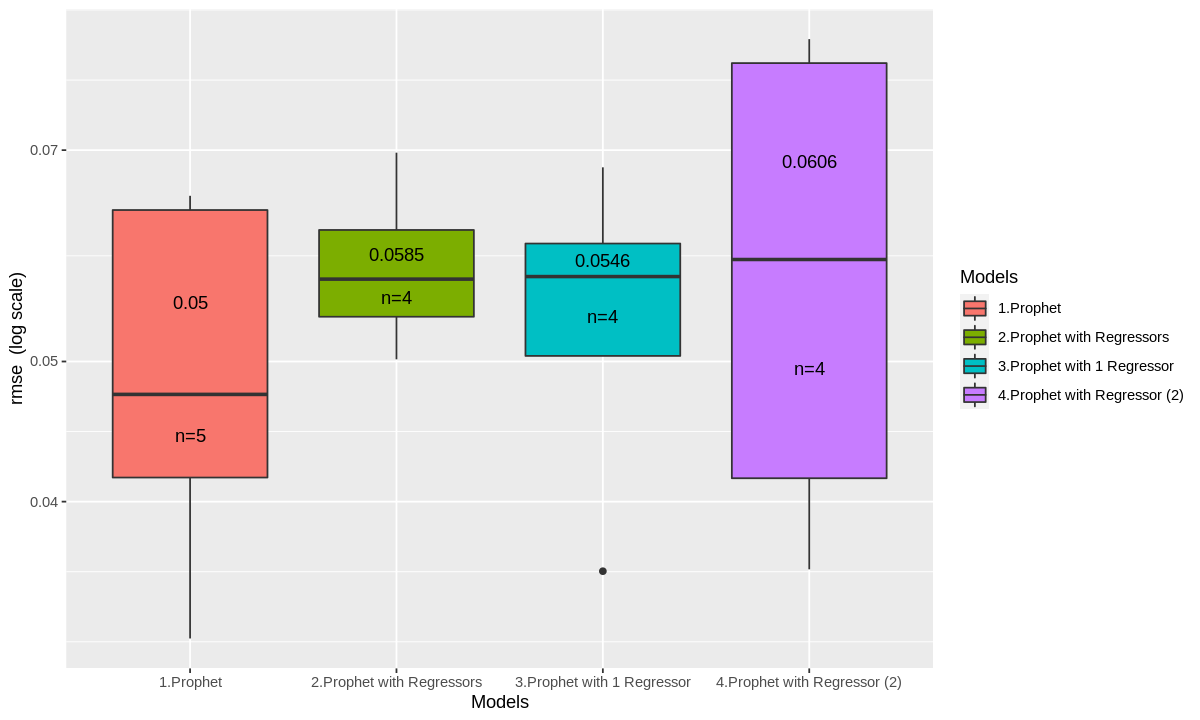

In [77]:
errors.1 <- new.get_result(result.m01.1, '1.Prophet')
errors.2 <- new.get_result(result.m01.2, '2.Prophet with Regressors')
errors.3 <- new.get_result(result.m01.3, '3.Prophet with 1 Regressor')
errors.4 <- new.get_result(result.m01.4, '4.Prophet with Regressor (2)')

x <- errors.1
x <- rbind(x, errors.2)
x <- rbind(x, errors.3)
x <- rbind(x, errors.4)
new.plot_errors(x, ylog=T)

### save result

In [ ]:
x <- result.m01.1
write.csv(x, file = "prophet_result_m0101.csv")
x <- result.m01.2
write.csv(x, file = "prophet_result_m0102.csv")
x <- result.m01.3
write.csv(x, file = "prophet_result_m0103.csv")
x <- result.m01.4
write.csv(x, file = "prophet_result_m0104.csv")

### load result

In [17]:
result.m01.1 <- read.csv(file = 'prophet_result_m0101.csv')
result.m01.2 <- read.csv(file = 'prophet_result_m0102.csv')
result.m01.3 <- read.csv(file = 'prophet_result_m0103.csv')
result.m01.4 <- read.csv(file = 'prophet_result_m0104.csv')

In [58]:
result.m01 <- result.m01.1

ERROR: Error in eval(expr, envir, enclos): object 'result.m01.1' not found


# BSTS

## Setting

In [94]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, expected.model.size=0,
                        model=NULL, niter=1000, ...) 
{
    if (!is.null(xreg)) {
        ### set params for fitting
        # organize data for fitting
        if (is.null(dim(x))) {x <- data.frame(x)}
        colnames(x) <- 'y'
        x.train <- cbind(x, xreg)
        x.train <- as.data.frame(x.train)
        
        if (is.null(model)) {
            n <- ncol(x.train)
            if ((expected.model.size < 1) | (expected.model.size > n)) {
                expected.model.size <- n
            }
            ss <- AddSemilocalLinearTrend(list(), x.train$y)
            model <- bsts(y ~ .,
                          state.specification = ss,
                          niter = niter,
                          data = x.train,
                          expected.model.size = expected.model.size)  # Passed to SpikeSlabPrior.
            olddata <- NULL
        } else {
            olddata <- x.train
        }
        
        ### set params for prediction
        # regessor assumption for future
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }

        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }

        xreg.all <- data.frame(xreg)
        xreg.coln <- colnames(xreg.all) # save name for the case of single xreg
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        } else {
            xreg.h <- as.ts(xreg.h) # convert to ts as xreg is ts
        }
        
        colnames(xreg.h) <- xreg.coln # match name to rbind
        
    } else {
        if (is.null(model)) {
            ss <- AddSemilocalLinearTrend(list(), x)
            model <- bsts(x, state.specification = ss, niter=niter, ...)
            olddata <- NULL
        } else {
            olddata <- x
        }
        xreg.h <- NULL
    }
    # predict
    fc <- predict(model, horizon=h, newdata=xreg.h, olddata=olddata)
    fc$model <- model
    return(fc)
}

bsts.forecast <- cv.forecast

In [96]:
cv.forecast.2 <- function(x, h, ...) {
    new.forecast(x, h, cv.forecast, ping=0, ...)
}

## Basic

In [97]:
result.m02.1 <- my.tsCV(train, cv.forecast.2, h=hori, window=wind, step=peri)

17 % done.

33 % done.

50 % done.

67 % done.

83 % done.

100 % done.



In [98]:
x <- result.m02.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regression with spike and slab priors

In [85]:
result.m02.2 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        xreg=trainx[,2:4], 
                        silent=F)

=-=-=-=-= Iteration 0 Mon Sep 26 13:52:04 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 13:52:07 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 13:52:11 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 13:52:14 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 13:52:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 13:52:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 13:52:24 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Sep 26 13:52:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Sep 26 13:52:31 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Sep 26 13:52:35 2022 =-=-=-=-=


20 % done.



=-=-=-=-= Iteration 0 Mon Sep 26 13:52:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 13:52:43 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 13:52:46 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 13:52:50 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 13:52:54 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 13:52:58 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 13:53:02 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Sep 26 13:53:06 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Sep 26 13:53:10 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Sep 26 13:53:13 2022 =-=-=-=-=


40 % done.



=-=-=-=-= Iteration 0 Mon Sep 26 13:53:17 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 13:53:21 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 13:53:24 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 13:53:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 13:53:32 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 13:53:35 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 13:53:39 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Sep 26 13:53:43 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Sep 26 13:53:46 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Sep 26 13:53:50 2022 =-=-=-=-=


60 % done.



=-=-=-=-= Iteration 0 Mon Sep 26 13:53:54 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 13:53:57 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 13:54:01 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 13:54:05 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 13:54:08 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 13:54:12 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 13:54:16 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Sep 26 13:54:19 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Sep 26 13:54:23 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Sep 26 13:54:26 2022 =-=-=-=-=


80 % done.



=-=-=-=-= Iteration 0 Mon Sep 26 13:54:31 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 13:54:34 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 13:54:38 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 13:54:41 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 13:54:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 13:54:49 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 13:54:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Sep 26 13:54:56 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Sep 26 13:54:59 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Sep 26 13:55:03 2022 =-=-=-=-=


100 % done.



In [86]:
x <- result.m02.2
from <- x[!is.na(x[,'forecast_start']),][,1][1]
from <- index(trainx[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-02-09"


In [89]:
result.m02.3 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        xreg=trainx[,2:4], silent=F,
                        xreg.msize=hori)

=-=-=-=-= Iteration 0 Mon Sep 26 13:55:25 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 13:55:28 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 13:55:31 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 13:55:35 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 13:55:38 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 13:55:42 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 13:55:45 2022 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Sep 26 13:55:49 2022 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Sep 26 13:55:52 2022 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Sep 26 13:55:56 2022 =-=-=-=-=
20 % done.=-=-=-=-= Iteration 0 Mon Sep 26 13:56:00 2022 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Sep 26 13:56:03 2022 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Sep 26 13:56:07 2022 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Sep 26 13:56:11 2022 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Sep 26 13:56:14 2022 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Sep 26 13:56:18 2022 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Sep 26 13:56:22 2022 =

## Compare Errors

In [90]:
my.figsize(10,6)

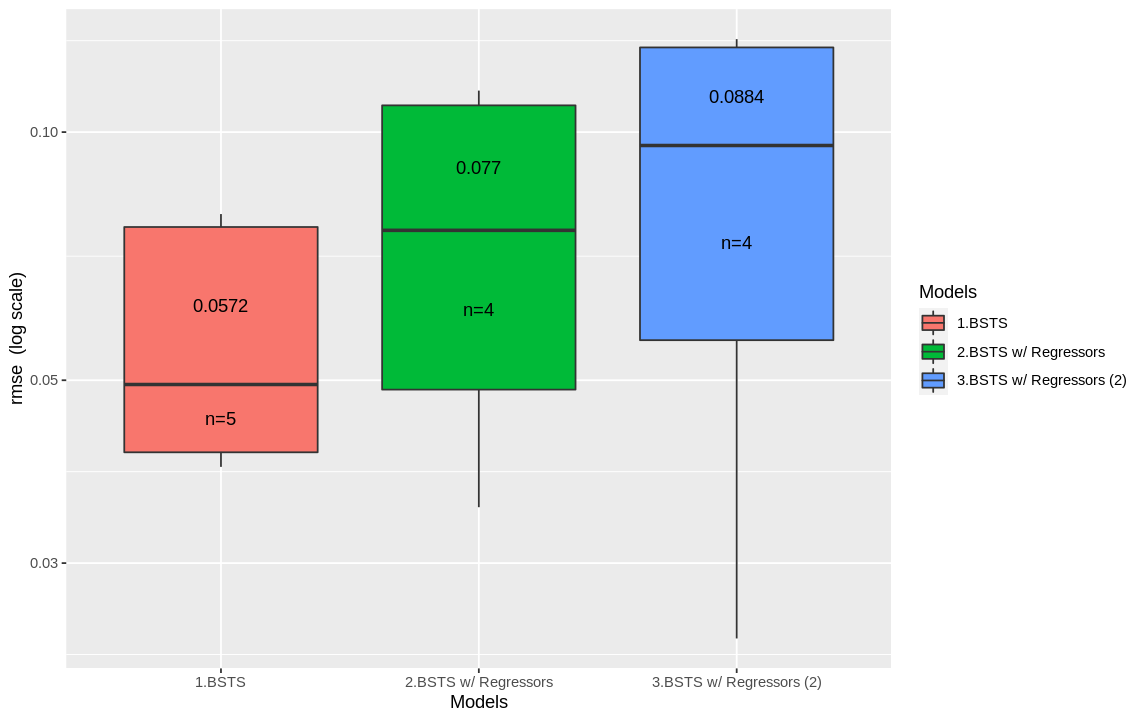

In [99]:
errors.1 <- new.get_result(result.m02.1, '1.BSTS')
errors.2 <- new.get_result(result.m02.2, '2.BSTS w/ Regressors')
errors.3 <- new.get_result(result.m02.3, '3.BSTS w/ Regressors (2)')

#x <- errors.1
x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)

new.plot_errors(x, ylog=T)

In [59]:
result.m02 <- result.m02.1

ERROR: Error in eval(expr, envir, enclos): object 'result.m02.1' not found


### save result

In [27]:
#x <- result.m02.1
#write.csv(x, file = "bsts_result_m0201.csv")
x <- result.m02.2
write.csv(x, file = "bsts_result_m0202.csv")
x <- result.m02.3
write.csv(x, file = "bsts_result_m0203.csv")

### load result

In [22]:
result.m02.1 <- read.csv(file = 'bsts_result_m0201.csv')
result.m02.2 <- read.csv(file = 'bsts_result_m0202.csv')
result.m02.3 <- read.csv(file = 'bsts_result_m0203.csv')

# ARIMA

## Setting

In [18]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL, order=NULL) {
    
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(NA)
        #colnames(xreg.h) <- colnames(xreg) # error with multiple xreg
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
        ## added for single day forecast
        xreg.coln <- colnames(xreg)
        xreg.h <- data.frame(xreg.h) # convert to frame for the case of single xreg
        if ((dim(xreg.h)[2]==1) & (dim(xreg.h)[1]==length(xreg.coln))) {
            xreg.h <- t(xreg.h) # the case of h==1
        } else {
            xreg.h <- as.ts(xreg.h) # convert to ts as xreg is ts
        }
        
    } else {
        xreg.h <- NULL
    }
    if (is.null(order)) {
        fc <- forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                                  xreg=xreg, 
                                  #lambda="auto" # not for negative value
                                  ), h=h, xreg=xreg.h)
    } else {
        fc <- forecast(Arima(x, order=order, seasonal=FALSE, 
                                  xreg=xreg, 
                                  ), h=h, xreg=xreg.h)
    }
    return(fc)
}

arima.forecast <- cv.forecast

In [19]:
cv.forecast.2 <- function(x, h, ...) {
    new.forecast(x, h, cv.forecast, ...)
}

## Basic

In [20]:
result.m03.1 <- my.tsCV(train, cv.forecast.2, h=hori, window=wind, step=peri, 
                        silent=T)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -8729.901
 ARIMA(1,0,0) with non-zero mean : -13486.9
 ARIMA(0,0,1) with non-zero mean : -10820.55
 ARIMA(0,0,0) with zero mean     : -8407.697
 ARIMA(2,0,0) with non-zero mean : -13491.63
 ARIMA(3,0,0) with non-zero mean : -13491.75
 ARIMA(4,0,0) with non-zero mean : -13496.44
 ARIMA(5,0,0) with non-zero mean : -13502.01
 ARIMA(5,0,1) with non-zero mean : -13509.96
 ARIMA(4,0,1) with non-zero mean : -13504.29
 ARIMA(5,0,2) with non-zero mean : -13507.99
 ARIMA(4,0,2) with non-zero mean : -13508.66
 ARIMA(5,0,1) with zero mean     : -13497.02

 Now re-fitting the best model(s) without approximations...

 ARIMA(5,0,1) with non-zero mean : -13497.21

 Best model: ARIMA(5,0,1) with non-zero mean 



17 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -13377.54
 ARIMA(1,1,0) with drift         : -13378.28
 ARIMA(0,1,1) with drift         : -13376.14
 ARIMA(0,1,0)                    : -13379.49
 ARIMA(1,1,1) with drift         : -13377.51

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,0)                    : -13388.23

 Best model: ARIMA(0,1,0)                    



33 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : -13351.94
 ARIMA(0,1,0) with drift         : -13329.65
 ARIMA(1,1,0) with drift         : -13329.34
 ARIMA(0,1,1) with drift         : -13328.48
 ARIMA(0,1,0)                    : -13331.64
 ARIMA(1,1,2) with drift         : -13333.18
 ARIMA(2,1,1) with drift         : -13367.24
 ARIMA(1,1,1) with drift         : -13327.34
 ARIMA(2,1,0) with drift         : -13329.21
 ARIMA(3,1,1) with drift         : -13330.64
 ARIMA(3,1,0) with drift         : -13332.29
 ARIMA(3,1,2) with drift         : Inf
 ARIMA(2,1,1)                    : -13368.81
 ARIMA(1,1,1)                    : -13329.32
 ARIMA(2,1,0)                    : -13331.19
 ARIMA(3,1,1)                    : -13332.67
 ARIMA(2,1,2)                    : -13353.95
 ARIMA(1,1,0)                    : -13331.32
 ARIMA(1,1,2)                    : -13348.06
 ARIMA(3,1,0)                    : -13334.28
 ARIMA(3,1,2)                    : Inf

 Now 

50 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : -13234.71
 ARIMA(1,1,0) with drift         : -13232.87
 ARIMA(0,1,1) with drift         : -13233.97
 ARIMA(0,1,0)                    : -13236.7
 ARIMA(1,1,1) with drift         : -13231.87

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,0)                    : -13245.39

 Best model: ARIMA(0,1,0)                    



67 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -13263.35
 ARIMA(0,0,0) with non-zero mean : -8706.059
 ARIMA(1,0,0) with non-zero mean : -13255.84
 ARIMA(0,0,1) with non-zero mean : -10773.99
 ARIMA(0,0,0) with zero mean     : -8448.555
 ARIMA(1,0,2) with non-zero mean : -13260.91
 ARIMA(2,0,1) with non-zero mean : -13259.89
 ARIMA(3,0,2) with non-zero mean : Inf
 ARIMA(2,0,3) with non-zero mean : -13259.02
 ARIMA(1,0,1) with non-zero mean : -13262.92
 ARIMA(1,0,3) with non-zero mean : -13261.08
 ARIMA(3,0,1) with non-zero mean : Inf
 ARIMA(3,0,3) with non-zero mean : Inf
 ARIMA(2,0,2) with zero mean     : -13255.47

 Now re-fitting the best model(s) without approximations...

 ARIMA(2,0,2) with non-zero mean : -13263

 Best model: ARIMA(2,0,2) with non-zero mean 



83 % done.




 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -13234.55
 ARIMA(0,0,0) with non-zero mean : -8691.834
 ARIMA(1,0,0) with non-zero mean : -13229.55
 ARIMA(0,0,1) with non-zero mean : -10751.25
 ARIMA(0,0,0) with zero mean     : -8433.02
 ARIMA(1,0,2) with non-zero mean : -13235.37
 ARIMA(0,0,2) with non-zero mean : -11866.88
 ARIMA(1,0,1) with non-zero mean : -13237.32
 ARIMA(2,0,1) with non-zero mean : -13225.93
 ARIMA(2,0,0) with non-zero mean : -13237.39
 ARIMA(3,0,0) with non-zero mean : -13234.61
 ARIMA(3,0,1) with non-zero mean : Inf
 ARIMA(2,0,0) with zero mean     : -13228.38

 Now re-fitting the best model(s) without approximations...

 ARIMA(2,0,0) with non-zero mean : -13235.12

 Best model: ARIMA(2,0,0) with non-zero mean 



100 % done.



In [21]:
x <- result.m03.1
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regression with ARIMA errors

In [22]:
result.m03.2 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                       silent=F,
                       xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14728.24
 Regression with ARIMA(0,1,0) errors : -14705.76
 Regression with ARIMA(1,1,0) errors : -14703.21
 Regression with ARIMA(0,1,1) errors : -14703.85
 Regression with ARIMA(0,1,0) errors : -14707.74
 Regression with ARIMA(1,1,2) errors : -14755.07
 Regression with ARIMA(0,1,2) errors : -14703.58
 Regression with ARIMA(1,1,1) errors : -14701.2
 Regression with ARIMA(1,1,3) errors : -14756.2
 Regression with ARIMA(0,1,3) errors : -14715.69
 Regression with ARIMA(2,1,3) errors : -14743.68
 Regression with ARIMA(1,1,4) errors : -14754.84
 Regression with ARIMA(0,1,4) errors : -14713.96
 Regression with ARIMA(2,1,4) errors : -14742.53
 Regression with ARIMA(1,1,3) errors : -14757.92
 Regression with ARIMA(0,1,3) errors : -14717.66
 Regression with ARIMA(1,1,2) errors : -14756.77
 Regression with ARIMA(2,1,3) errors : -14745.4
 Regression with ARIMA(1,1,4) errors : -14756.51
 Regression

20 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14688.58
 Regression with ARIMA(1,1,0) errors : -14687.3
 Regression with ARIMA(0,1,1) errors : -14686.7
 Regression with ARIMA(0,1,0) errors : -14690.58
 Regression with ARIMA(1,1,1) errors : -14685.35

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -14699.9

 Best model: Regression with ARIMA(0,1,0) errors 



40 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14648.88
 Regression with ARIMA(1,1,0) errors : -14646.36
 Regression with ARIMA(0,1,1) errors : -14647.06
 Regression with ARIMA(0,1,0) errors : -14650.88
 Regression with ARIMA(1,1,1) errors : -14644.49

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -14660.19

 Best model: Regression with ARIMA(0,1,0) errors 



60 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14557.56
 Regression with ARIMA(1,1,0) errors : -14555.41
 Regression with ARIMA(0,1,1) errors : -14555.93
 Regression with ARIMA(0,1,0) errors : -14559.56
 Regression with ARIMA(1,1,1) errors : -14553.98

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -14568.83

 Best model: Regression with ARIMA(0,1,0) errors 



80 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14466.15
 Regression with ARIMA(1,1,0) errors : -14464.59
 Regression with ARIMA(0,1,1) errors : -14465.14
 Regression with ARIMA(0,1,0) errors : -14468.15
 Regression with ARIMA(1,1,1) errors : -14463.16

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -14477.38

 Best model: Regression with ARIMA(0,1,0) errors 



100 % done.



In [23]:
x <- result.m03.2
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Regressor mean of smaller period for forecast 
- Regressor mean for forecast is calculated from the number of latest 'horizon' period
- the 1st model used the number of latest 'window' period for the calc of regressor mean

In [24]:
result.m03.3 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        xreg.msize=hori,
                        xreg=trainx[,2:4])


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14728.24
 Regression with ARIMA(0,1,0) errors : -14705.76
 Regression with ARIMA(1,1,0) errors : -14703.21
 Regression with ARIMA(0,1,1) errors : -14703.85
 Regression with ARIMA(0,1,0) errors : -14707.74
 Regression with ARIMA(1,1,2) errors : -14755.07
 Regression with ARIMA(0,1,2) errors : -14703.58
 Regression with ARIMA(1,1,1) errors : -14701.2
 Regression with ARIMA(1,1,3) errors : -14756.2
 Regression with ARIMA(0,1,3) errors : -14715.69
 Regression with ARIMA(2,1,3) errors : -14743.68
 Regression with ARIMA(1,1,4) errors : -14754.84
 Regression with ARIMA(0,1,4) errors : -14713.96
 Regression with ARIMA(2,1,4) errors : -14742.53
 Regression with ARIMA(1,1,3) errors : -14757.92
 Regression with ARIMA(0,1,3) errors : -14717.66
 Regression with ARIMA(1,1,2) errors : -14756.77
 Regression with ARIMA(2,1,3) errors : -14745.4
 Regression with ARIMA(1,1,4) errors : -14756.51
 Regression

20 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14688.58
 Regression with ARIMA(1,1,0) errors : -14687.3
 Regression with ARIMA(0,1,1) errors : -14686.7
 Regression with ARIMA(0,1,0) errors : -14690.58
 Regression with ARIMA(1,1,1) errors : -14685.35

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -14699.9

 Best model: Regression with ARIMA(0,1,0) errors 



40 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14648.88
 Regression with ARIMA(1,1,0) errors : -14646.36
 Regression with ARIMA(0,1,1) errors : -14647.06
 Regression with ARIMA(0,1,0) errors : -14650.88
 Regression with ARIMA(1,1,1) errors : -14644.49

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -14660.19

 Best model: Regression with ARIMA(0,1,0) errors 



60 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14557.56
 Regression with ARIMA(1,1,0) errors : -14555.41
 Regression with ARIMA(0,1,1) errors : -14555.93
 Regression with ARIMA(0,1,0) errors : -14559.56
 Regression with ARIMA(1,1,1) errors : -14553.98

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -14568.83

 Best model: Regression with ARIMA(0,1,0) errors 



80 % done.




 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14466.15
 Regression with ARIMA(1,1,0) errors : -14464.59
 Regression with ARIMA(0,1,1) errors : -14465.14
 Regression with ARIMA(0,1,0) errors : -14468.15
 Regression with ARIMA(1,1,1) errors : -14463.16

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(0,1,0) errors : -14477.38

 Best model: Regression with ARIMA(0,1,0) errors 



100 % done.



In [25]:
x <- result.m03.3
from <- na.omit(x[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-01-24"


## Compare Errors

In [28]:
my.figsize(10,6)

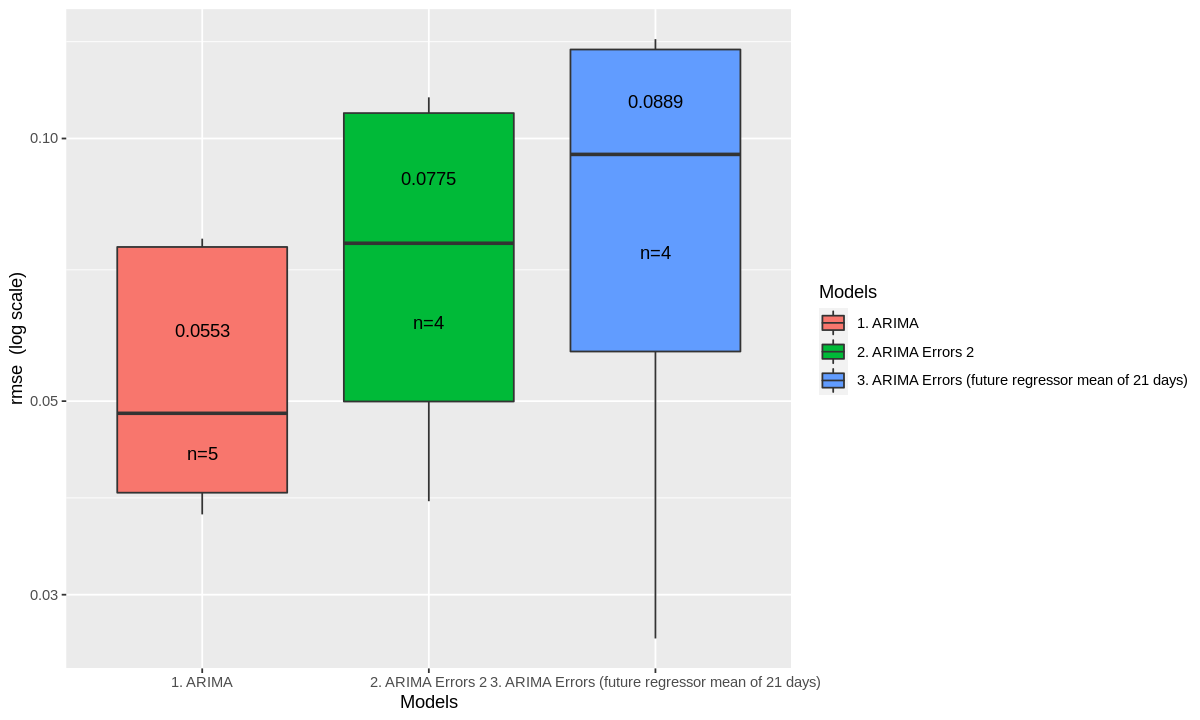

In [27]:
errors.1 <- new.get_result(result.m03.1, '1. ARIMA')
errors.2 <- new.get_result(result.m03.2, '2. ARIMA Errors 2')
n <- paste('3. ARIMA Errors (future regressor mean of', hori ,'days)', sep=' ')
errors.3 <- new.get_result(result.m03.3, n)

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)

new.plot_errors(x, ylog=T)

### save result

In [27]:
x <- result.m03.1
write.csv(x, file = "arima_result_m0301.csv")
x <- result.m03.2
write.csv(x, file = "arima_result_m0302.csv")
x <- result.m03.3
write.csv(x, file = "arima_result_m0303.csv")

### load result

In [25]:
result.m03.1 <- read.csv(file = 'arima_result_m0301.csv')
result.m03.2 <- read.csv(file = 'arima_result_m0302.csv')
result.m03.3 <- read.csv(file = 'arima_result_m0303.csv')

In [60]:
result.m03 <- result.m03.1

# ARIMA+GARCH

## Setting

In [29]:
cv.forecast <- function(x, h, 
                        mxreg=NULL, mxreg.msize=NULL, 
                        vxreg=NULL, vxreg.msize=NULL,
                        order=NULL) {
    forc <- ag2.forecast(x, h, 
                         mxreg=mxreg, mxreg.msize=mxreg.msize, 
                         vxreg=vxreg, vxreg.msize=vxreg.msize, 
                         out.sample=0, order=order)
    if (!is.na(forc)) {
        fc <- list(method = "ARIMA+GARCH Forecasting", mean=forc@forecast$seriesFor[,1],
                   arima.order=forc@users$arima.order)
        attr(fc$mean, "names") <- NULL
        return(fc)
    }
}

agarch.forecast <- cv.forecast

In [30]:
cv.forecast.2 <- function(x, h, ...) {
    new.forecast(x, h, cv.forecast, ...)
}

## Basic

In [31]:
result.m04.1 <- my.tsCV(train, cv.forecast.2, h=hori, window=wind, step=peri,
                        silent=F)

[1] "GARCH model does not converge"


17 % done.

33 % done.

50 % done.

67 % done.

83 % done.

100 % done.



## Regressors for mean

In [32]:
result.m04.2 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        mxreg=trainx[,2:4], silent=F)

20 % done.

40 % done.

60 % done.

80 % done.

100 % done.



## Regressors for variance

In [33]:
result.m04.3 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        vxreg=trainx[,2:4], silent=F)

20 % done.

40 % done.

60 % done.

80 % done.

100 % done.



## Regressors for both of mean & variance

In [34]:
result.m04.4 <- my.tsCV(trainx[,1], cv.forecast.2, h=hori, window=wind, step=peri,
                        mxreg=trainx[,2:4], vxreg=trainx[,2:4], 
                        silent=F)

20 % done.

40 % done.

60 % done.

80 % done.

100 % done.



In [35]:
x <- result.m04.4
from <- x[!is.na(x[,'forecast_start']),][,1][1]
from <- index(trainx[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-02-09"


## Compare Errors

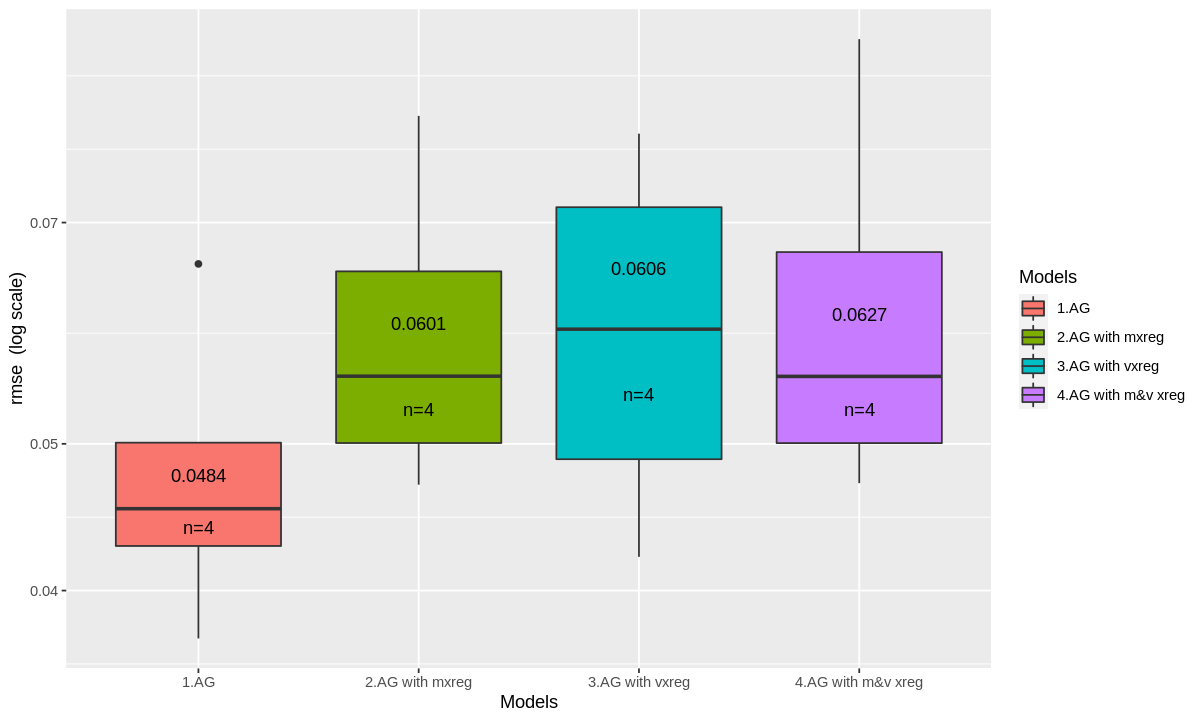

In [36]:
errors.1 <- new.get_result(result.m04.1, '1.AG')
errors.2 <- new.get_result(result.m04.2, '2.AG with mxreg')
errors.3 <- new.get_result(result.m04.3, '3.AG with vxreg')
errors.4 <- new.get_result(result.m04.4, '4.AG with m&v xreg')

x <- rbind(errors.1, errors.2)
x <- rbind(x, errors.3)
x <- rbind(x, errors.4)

new.plot_errors(x, ylog=T)

### save result

In [31]:
x <- result.m04.1
write.csv(x, file = "agarch_result_m0401.csv")
x <- result.m04.2
write.csv(x, file = "agarch_result_m0402.csv")
x <- result.m04.3
write.csv(x, file = "agarch_result_m0403.csv")
x <- result.m04.4
write.csv(x, file = "agarch_result_m0404.csv")

### load result

In [28]:
result.m04.1 <- read.csv(file = 'agarch_result_m0401.csv')
result.m04.2 <- read.csv(file = 'agarch_result_m0402.csv')
result.m04.3 <- read.csv(file = 'agarch_result_m0403.csv')
result.m04.4 <- read.csv(file = 'agarch_result_m0404.csv')

In [61]:
result.m04 <- result.m04.1

# Gradient Boosting

## Setting

In [40]:
xgb.eval <- function(
    train.label, train.features, test.label, test.features,
    nrounds = 1000, early_stopping_rounds = 3,
    max_depth = 6, 
    eta = 0.3, # learning rate
    # In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. 
    # The larger min_child_weight is, the more conservative the algorithm will be. range: [0,?]
    #min_child_weight = 1 ,
    # Minimum loss reduction required to make a further partition on a leaf node of the tree. 
    # The larger gamma is, the more conservative the algorithm will be. range: [0,?]
    #gamma = 0,
    verbose=0,
    sample.n=0,
    result.error=FALSE
) 
{
    if (is.null(dim(test.features))) {
        # conver to matrix for the case of 1 day prediction
        test.features <- t(test.features)
    }
    model <- xgboost(data = train.features,
                     label = train.label,
                     nrounds = nrounds,
                     objective = "reg:squarederror",
                     early_stopping_rounds = early_stopping_rounds,
                     max_depth = max_depth,
                     eta = eta,
                     verbose=verbose)

    pred <- predict(model, test.features)
    
    if (result.error) {
        h = length(pred)
        idx = 1:h
        if ((sample.n>0) & (sample.n<h)) {
            idx <- sort(sample(idx, sample.n))
        }

        # calc errors
        rmse <- sqrt((pred[idx] - test.label[idx])^2)
        mape <- abs(1 - pred[idx] / test.label[idx])
        result <- list(rmse.mean=mean(rmse), rmse.sigma=sd(rmse), 
                       mape.mean=mean(mape), mape.sigma=sd(mape))
        return(result)
    } else {
        return(pred)
    }
}


xgb.gridsearch <- function(label, features, test.h, hyper_grid, verbose=1) {
    len <- length(label)
    idx.train <- 1:(len-test.h)
    idx.test <- (len-test.h+1):(len)
    train.label <- label[idx.train]
    train.features <- features[idx.train,]
    test.label <- label[idx.test]
    test.features <- features[idx.test,]
    
    xgb_test_rmse <- NULL
    xgb_test_mape <- NULL

    for (j in 1:nrow(hyper_grid)) {
        #set.seed(123)
        
        errors <- xgb.eval(train.label, train.features, test.label, test.features,
                            nrounds = 1000, early_stopping_rounds = 3,
                            max_depth = hyper_grid$max_depth[j], 
                            eta = hyper_grid$eta[j],
                            verbose=0, result.error=TRUE)
        # calc errors
        xgb_test_rmse[j] <- errors$rmse.mean
        xgb_test_mape[j] <- errors$mape.mean
    }

    #ideal hyperparamters
    r <- hyper_grid[which.min(xgb_test_rmse), ]
    if (verbose>0) {
        print(r)
    }
    return(r)
}


xgb.tsCV <- function (label, features, max_depth = 6, eta = .25,
                      h = 1, window = NULL, initial = 0, step = 1, 
                      count.freq=0.1, ...) 
{
    y <- as.ts(label)
    n <- length(y)
    step <- round(step)
    step_ind <- seq(step, n - 1L, by = step)

    if (initial >= n) 
        stop("initial period too long")

    xreg <- ts(as.matrix(features))
    if (NROW(xreg) != length(y)) 
        stop("features must be of the same size as label")
    tsp(xreg) <- tsp(y)
 
    if (is.null(window)) {
        indx <- seq(1 + initial, n - 1L)
    } else {
        indx <- seq(window + initial, n - 1L, by = 1L)
    }
    indx <- intersect(indx, step_ind)

    e.cols <- c('forecast_start', 'forecast_end', 
                'rmse.mean', 'rmse.sigma', 'mape.mean', 'mape.sigma')
    e <- ts(matrix(NA_real_, nrow = floor(n/step), ncol = length(e.cols)))
    colnames(e) <- e.cols
    
    ###
    hyper_grid <- expand.grid(max_depth = max_depth, eta = eta)
    if (nrow(hyper_grid)>1) {
        hyper_grid.flag <- TRUE
    } else {
        hyper_grid.flag <- FALSE
    }
    

    indx.len <- length(indx)
    by <- round(count.freq*indx.len)
    by <- max(1, by)
    print.when <- seq(0, indx.len, by=by)
    
    cnt <- 0
    
    for (i in indx) {
        # get new start of subset of y & xreg
        if (is.null(window)) {
            start <- 1L
        } else {
            if (i - window >= 0L) {
                start <- i - window + 1L
            } else {
                stop("small window")
            }
        }
        train.label <- subset(y, start=start, end = i)
        train.features <- as.matrix(subset(xreg, start=start, end=i))
        
        # get test data
        start <- i+1
        end <- i+h
        if (end <= nrow(xreg)) {
            test.label <- subset(y, start=start, end=end)
            test.features <- as.matrix(subset(xreg, start=start, end=end))
        } else {
            next
        }
        
        # tune hyperparams
        if (hyper_grid.flag) {
            res <- xgb.gridsearch(train.label, train.features, h, hyper_grid)
            max_depth.best <- res$max_depth
            eta.best <- res$eta
        } else {
            max_depth.best <- max_depth
            eta.best <- eta
        }
        
        # train model
        errors <- xgb.eval(train.label, train.features, test.label, test.features,
                    nrounds = 1000, early_stopping_rounds = 3,
                    max_depth = max_depth.best,
                    eta = eta.best, result.error=TRUE, ...)
        # calc errors
        e[i/step, ] <- c(start, end, errors$rmse.mean, errors$rmse.sigma, 
                                     errors$mape.mean, errors$mape.sigma)

        cnt <- cnt + 1
        if (cnt %in% print.when) {
            print(sprintf("%0.0f %% done.", 100*cnt/length(indx)))
        }
    }
    #return(na.omit(e)) # times of NA kept in e as attr(na.action)
    return(e)
}


xgb.tsCV.mean <- function(label, features, cols=c(1,2,3,5), ...) {
    e <- xgb.tsCV(label, features, ...)
    result <- e[,cols]
    colnames(result) <- c('forecast_start', 'forecast_end', 'rmse', 'mape')
    return(result)
}

### set label & features

In [38]:
train.ml <- merge(lag.xts(trainx$y, -lookahead), trainx, join='left', fill=NA)
colnames(train.ml) <- c('logret_fwd', 'logret', 'rsi','bbands','macd')
train.ml <- na.omit(train.ml)

x <- head(train.ml, lookahead+6)
head(x)
tail(x)
#tail(train.ml)

idx.label <- 1
idx.feautres <- 2:5

             logret_fwd     logret      rsi    bbands        macd
1991-02-19 -0.003987479 0.10602550 72.59254 0.8419486 -0.03641515
1991-02-20  0.003935860 0.09798126 66.25313 0.7706927 -0.18551057
1991-02-21  0.006853764 0.10585688 66.00481 0.7330987 -0.30953562
1991-02-22  0.011366830 0.10194779 66.54491 0.7402938 -0.39546732
1991-02-25  0.024316594 0.09259647 67.84742 0.7305630 -0.43573971
1991-02-26  0.033979664 0.07655978 60.80133 0.6379610 -0.55105032

            logret_fwd       logret      rsi    bbands       macd
1991-03-20 0.043297723 -0.003987479 52.32729 0.2955472 -0.5878001
1991-03-21 0.038451421  0.003935860 50.29479 0.3135024 -0.6182388
1991-03-22 0.038123240  0.006853764 51.65309 0.2490278 -0.6049896
1991-03-25 0.034364782  0.011366830 55.10298 0.4057512 -0.5386086
1991-03-26 0.007808953  0.024316594 62.94322 0.6945332 -0.3702197
1991-03-27 0.009730005  0.033979664 61.25189 0.8281562 -0.2741769

## Default

In [41]:
result.m05.1 <- xgb.tsCV.mean(train.ml[,idx.label], train.ml[,idx.feautres], 
                              h=1, window=wind, step=peri)

[1] "25 % done."
[1] "50 % done."
[1] "75 % done."
[1] "100 % done."


In [42]:
x <- result.m05.1
from <- x[!is.na(x[,'forecast_start']),][,1][1]
from <- index(trainx[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 2000-02-09"


## Tuning params

In [53]:
#max_depth <- seq(4, 8, 1)
#eta <- c(0.01, 0.05, 0.1, 0.2, 0.3)

max_depth <- seq(5, 7, 1)
eta <- c(0.01, 0.1)

x <- expand.grid(max_depth = max_depth, eta = eta)
nrow(x)

[1] 6

In [54]:
result.m05.2 <- xgb.tsCV.mean(train.ml[,idx.label], train.ml[,idx.feautres], 
                              h=hori, window=wind, step=peri,
                              max_depth = max_depth, eta = eta)

  max_depth eta
4         5 0.1
[1] "25 % done."
  max_depth  eta
3         7 0.01
[1] "50 % done."
  max_depth  eta
2         6 0.01
[1] "75 % done."


## Compare Models

In [55]:
my.figsize(10,6)

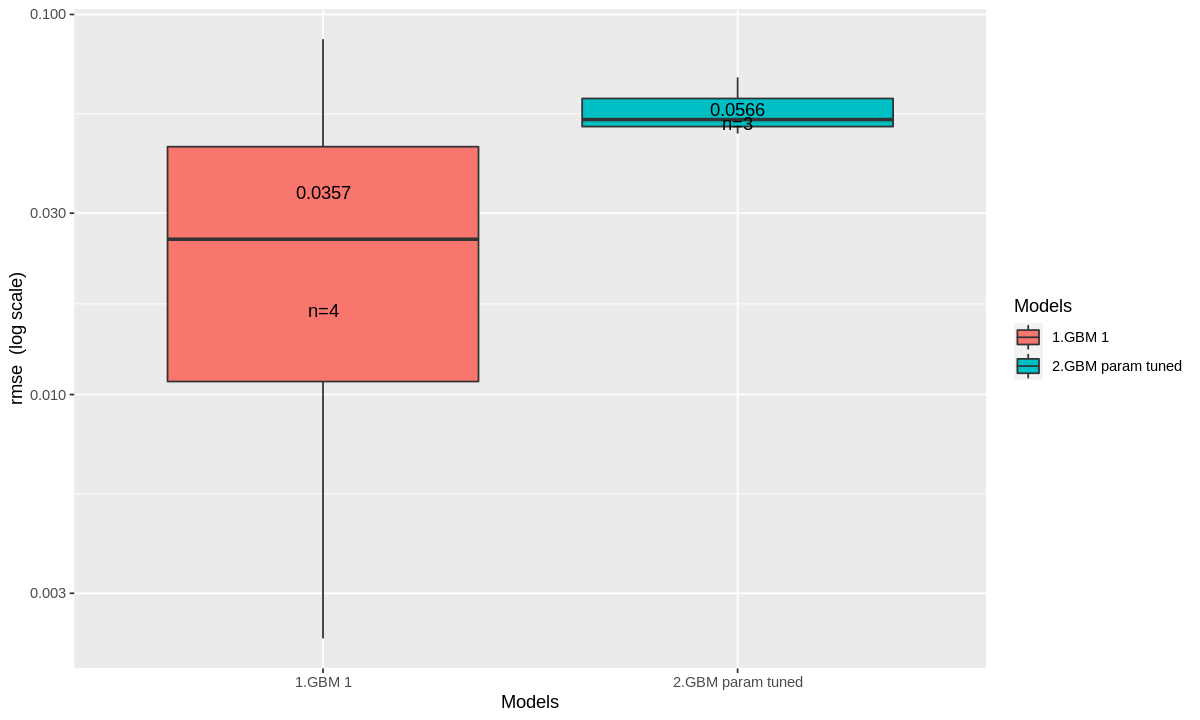

In [56]:
errors.1 <- new.get_result(result.m05.1, '1.GBM 1')
errors.2 <- new.get_result(result.m05.2, '2.GBM param tuned')

x <- errors.1
x <- rbind(x, errors.2)

new.plot_errors(x, ylog=T)

### save result

In [54]:
x <- result.m05.1
write.csv(x, file = "gbm_result_m0501.csv")
x <- result.m05.2
write.csv(x, file = "gbm_result_m0502.csv")

### load result

In [32]:
result.m05.1 <- read.csv(file = 'gbm_result_m0501.csv')
result.m05.2 <- read.csv(file = 'gbm_result_m0502.csv')

In [62]:
result.m05 <- result.m05.1

# Model Comparision

In [64]:
#errors.1 <- new.get_result(result.m01, '1. Prophet')
#errors.2 <- new.get_result(result.m02, '2. BSTS')
errors.3 <- new.get_result(result.m03, '3. ARIMA')
errors.4 <- new.get_result(result.m04, '4. ARIMA+GARCH')
errors.5 <- new.get_result(result.m05, '5. Gradient Boosting')

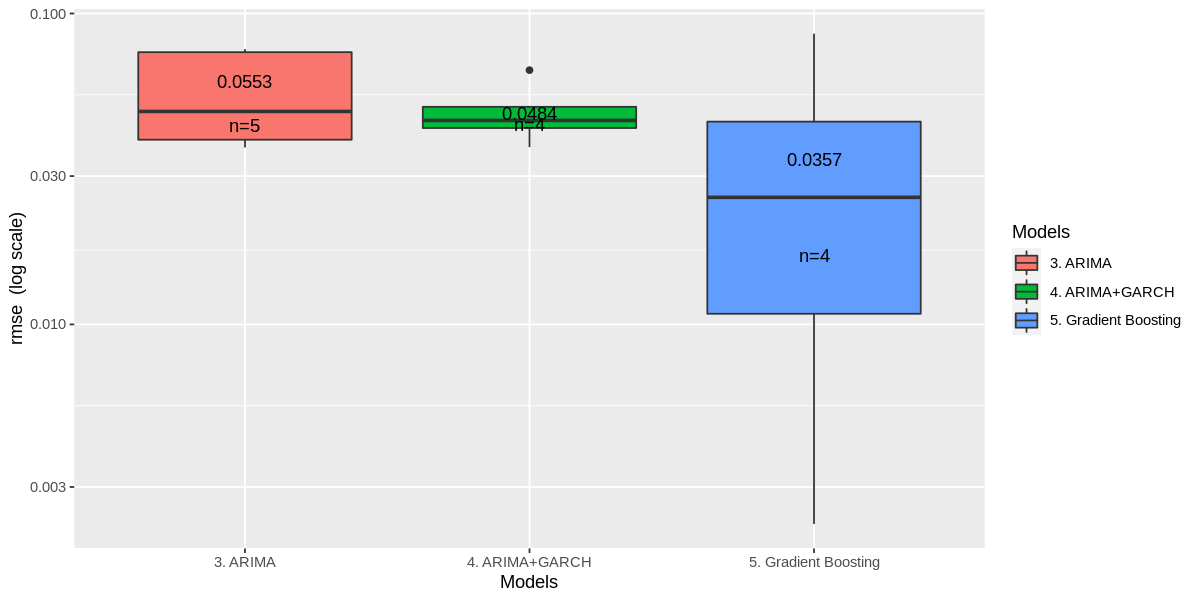

In [65]:
#errors.list <- list(errors.1, errors.2, errors.3, errors.4, errors.5)
errors.list <- list(errors.3, errors.4, errors.5)
x <- errors.list[[1]]
for (e in errors.list[2:length(errors.list)]) {
    x <- rbind(x, e)
}

my.figsize(10, 5)
new.plot_errors(x, ylog=T)

In [ ]:
write.csv(x, file = "result_comparison.csv")

## Forecast with best model

In [276]:
h <- 21
x.train <- train[1:wind]
x.test <- train[(wind+1):(wind+h)]

In [277]:
my.figsize(10,5)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -8729.901
 ARIMA(1,0,0) with non-zero mean : -13486.9
 ARIMA(0,0,1) with non-zero mean : -10820.55
 ARIMA(0,0,0) with zero mean     : -8407.697
 ARIMA(2,0,0) with non-zero mean : -13491.63
 ARIMA(3,0,0) with non-zero mean : -13491.75
 ARIMA(4,0,0) with non-zero mean : -13496.44
 ARIMA(5,0,0) with non-zero mean : -13502.01
 ARIMA(5,0,1) with non-zero mean : -13509.96
 ARIMA(4,0,1) with non-zero mean : -13504.29
 ARIMA(5,0,2) with non-zero mean : -13507.99
 ARIMA(4,0,2) with non-zero mean : -13508.66
 ARIMA(5,0,1) with zero mean     : -13497.02

 Now re-fitting the best model(s) without approximations...

 ARIMA(5,0,1) with non-zero mean : -13497.21

 Best model: ARIMA(5,0,1) with non-zero mean 



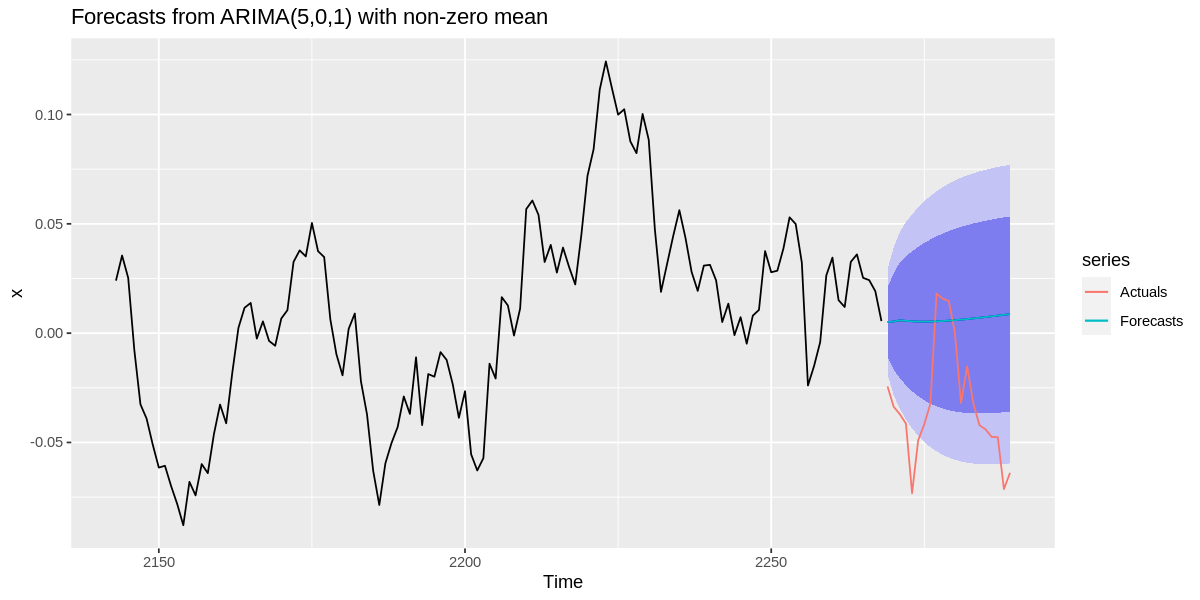

In [278]:
fc <- arima.forecast(x.train, h)
my.plot_forecast(fc, future=h, test=x.test, past=h*6)

NULL

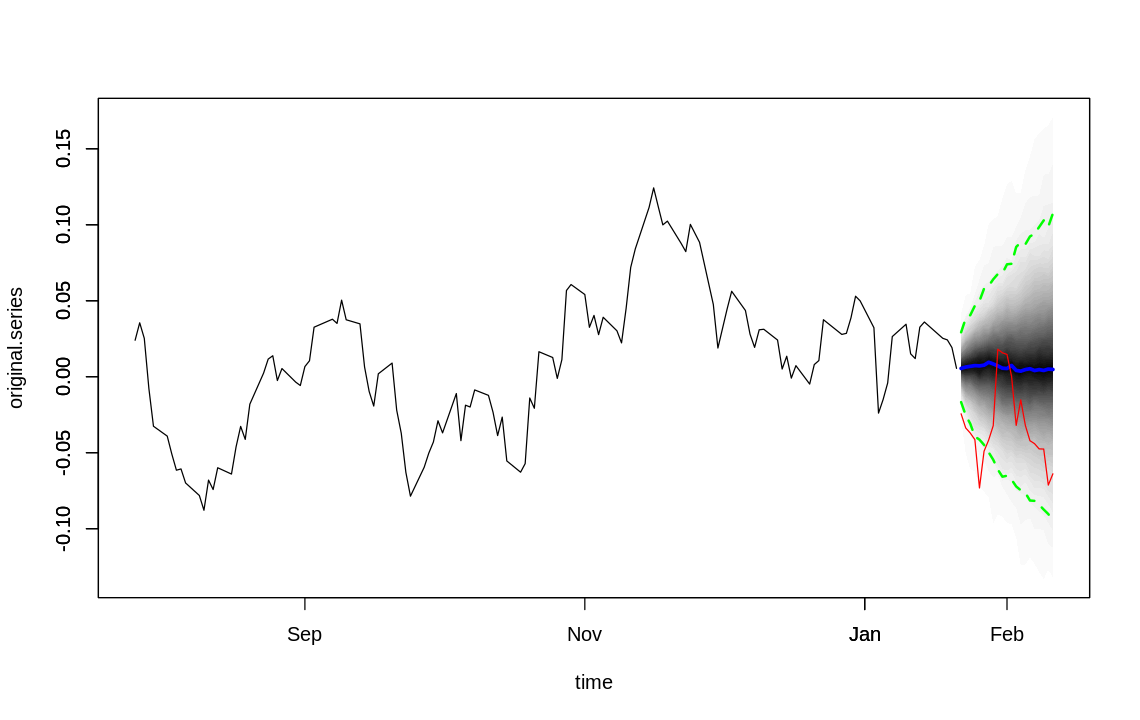

In [95]:
bsts.lines <- function(fc, obs, ...) {
    n1 <- ncol(fc$distribution)
    time <- index(fc$original.series)
    deltat <- tail(diff(tail(time, 2)), 1)
    pred.time <- tail(time, 1) + (1:n1) * deltat
    obs <- obs[1:length(pred.time)]
    index(obs) <- pred.time
    #l <- lines(obs)
    l <- lines(pred.time, as.numeric(obs), ...)
    return(l)
}

fc <- bsts.forecast(x.train, h, ping=0)

my.figsize(9.5,6)
plot(fc, plot.original=h*6)
bsts.lines(fc, x.test, col='red')

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



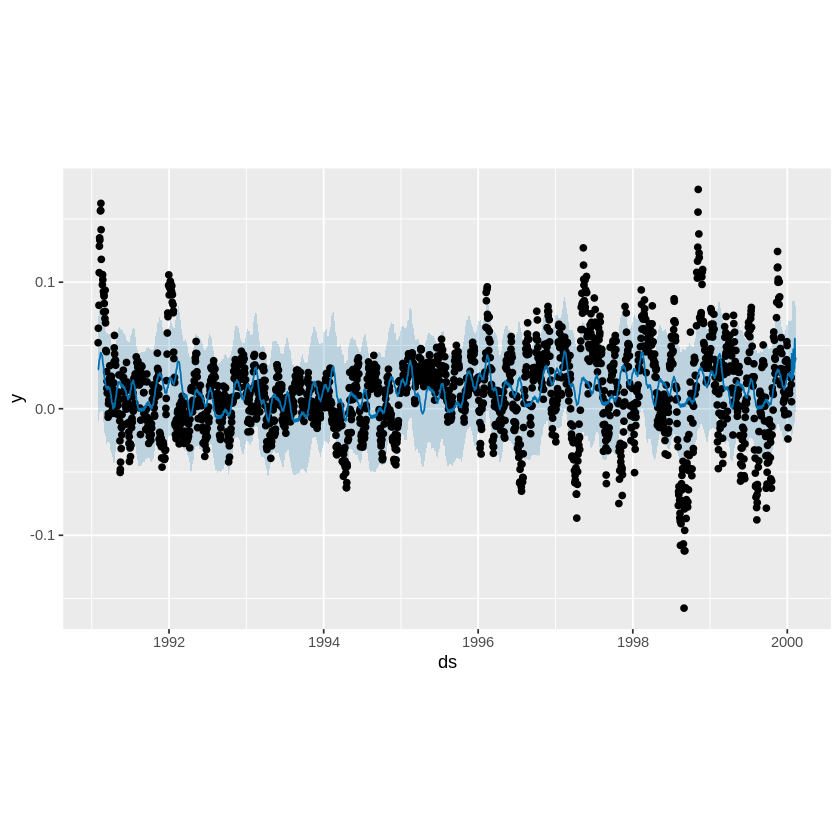

In [60]:
# testing
h <- 21
x.train <- train[1:wind]
x.test <- train[(wind+1):(wind+h)]

#fc <- prophet.forecast(x.train, h, result.error=TRUE)
fc <- prophet.forecast(x.train, h)
plot(fc$model, fc$pred)

In [291]:
fc <- prophet.forecast(x.train, h, result.error=F)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [294]:
str(plot(fc$model, fc$pred, type='l'))

List of 9
 $ data       :'data.frame':	2289 obs. of  20 variables:
  ..$ ds                        : POSIXct[1:2289], format: "1991-01-31" "1991-02-01" ...
  ..$ y                         : num [1:2289] 0.0522 0.0636 0.0817 0.1076 0.1285 ...
  ..$ trend                     : num [1:2289] 0.024 0.0239 0.0239 0.0239 0.0238 ...
  ..$ additive_terms            : num [1:2289] 0.00722 0.00715 0.01232 0.01399 0.01474 ...
  ..$ additive_terms_lower      : num [1:2289] 0.00722 0.00715 0.01232 0.01399 0.01474 ...
  ..$ additive_terms_upper      : num [1:2289] 0.00722 0.00715 0.01232 0.01399 0.01474 ...
  ..$ weekly                    : num [1:2289] -0.00562 -0.00683 -0.00537 -0.00495 -0.00543 ...
  ..$ weekly_lower              : num [1:2289] -0.00562 -0.00683 -0.00537 -0.00495 -0.00543 ...
  ..$ weekly_upper              : num [1:2289] -0.00562 -0.00683 -0.00537 -0.00495 -0.00543 ...
  ..$ yearly                    : num [1:2289] 0.0128 0.014 0.0177 0.0189 0.0202 ...
  ..$ yearly_lower         